data/
│
├── features/
│   ├── noise_features.csv
│   ├── ndvi_features.csv
│   ├── poi_features.csv
│   ├── temporal_features.csv
│   └── combined_features.csv
│
├── labels/
│   └── proxy_stress_labels.csv  (temporary)
│
models/
│   ├── preprocessing.py
│   ├── train_model.py
│   ├── evaluate_model.py
│   ├── explain_model.py
│   └── feature_importance.py


Columns available: 511
Participants: 116

Participants: 114
Total foot intervals: 2532

Stress label distribution:
stress
1    0.63
0    0.37
Name: proportion, dtype: float64

Average HR (Mean_HR_cond) per class:
              mean        std        min         max
stress                                              
0        83.839489  15.646281  44.137931  166.956522
1       110.349059  14.418897  72.452830  182.857143


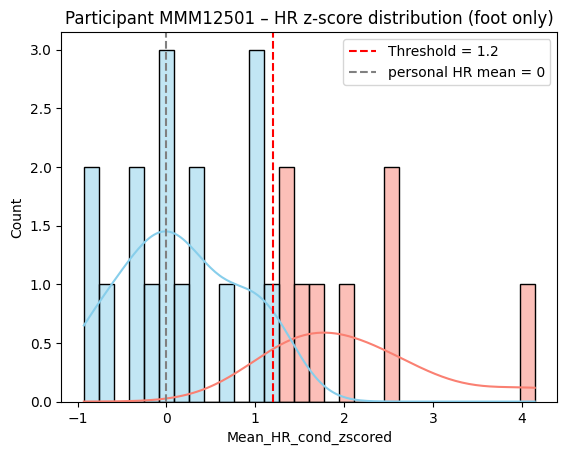

In [1]:
import pandas as pd
import numpy as np

data_merged = pd.read_pickle("/home/s232713/data/final_merged_data.pkl")

print("Columns available:", data_merged.columns.size)
print("Participants:", data_merged['INDIVID'].nunique())

"""
data_merged['Mean_HR_cond_zscored'] = data_merged.groupby('INDIVID')['Mean_HR_cond'].transform(
    lambda x: (x - x.mean()) / x.std(ddof=0)
)
"""

threshold = 1.2 # z-score threshold for stress labeling: individual is considered stressed if their HR is above 1.2 std from their mean HR
data_merged['stress'] = (data_merged['Mean_HR_cond_zscored'] > threshold).astype(int)

foot = data_merged[(data_merged['Mode_id'] == 29) & (data_merged['Deleted'] == False) & (data_merged['Validated'] == True)] # filter for the one i use

print("\nParticipants:", foot['INDIVID'].nunique())
print("Total foot intervals:", len(foot))
print("\nStress label distribution:")
print(foot['stress'].value_counts(normalize=True).round(3))

print("\nAverage HR (Mean_HR_cond) per class:")
print(foot.groupby('stress')['Mean_HR_cond'].describe()[['mean','std','min','max']])

# check one participant visually 

import seaborn as sns
import matplotlib.pyplot as plt

example_id = foot['INDIVID'].unique()[0]  # pick first participant
df_plot = foot[foot['INDIVID'] == example_id]
sns.histplot(df_plot, x='Mean_HR_cond_zscored', hue='stress', bins=30, kde=True, palette=['skyblue','salmon'])
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.axvline(0, color='gray', linestyle='--', label=f'personal HR mean = {0}')
plt.title(f'Participant {example_id} – HR z-score distribution (foot only)')
plt.legend()
plt.show()




Total participants: 116



Participants with walking data: 114
Total walking intervals: 2532

Overall stress label distribution:
stress
0    0.662
1    0.338
Name: proportion, dtype: float64

Average HR per stress class:
              mean        std        min         max
stress                                              
0        92.185234  16.168482  44.137931  135.903169
1       116.923641  14.941003  82.940691  182.857143

Per-participant stress ratio summary (top 10):
          threshold_used  stress_ratio     hr_mean   n
INDIVID                                               
MMM23701       93.244176      1.000000   93.658537   1
MMM21501       82.347747      1.000000  103.163208   2
MMM26401       98.270812      1.000000  113.305033   2
MMM20901      103.668601      0.833333  111.776595   6
MMM15301       99.702901      0.833333  108.012658   6
MMM25501      105.659948      0.800000  110.370455  15
MMM20301      104.203064      0.733333  112.010739  15
MMM19601       93.857179      0.727273  100.387679

/tmp/ipykernel_1724010/3061737335.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_merged = data_merged.groupby('INDIVID', group_keys=False).apply(adaptive_threshold, quantile=quantile)


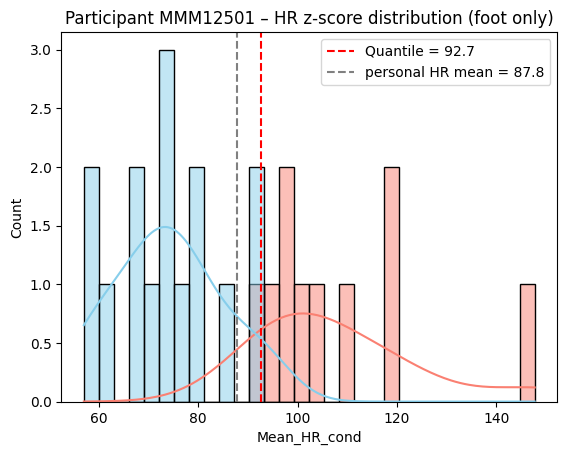

In [2]:
# adapting stress threshold per individual based on quantiles

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data_merged = pd.read_pickle("/home/s232713/data/final_merged_data.pkl")

print("Total participants:", data_merged['INDIVID'].nunique())

def adaptive_threshold(df, quantile):
    """
    For each individual:
      - compute the HR value above which the top X% of HRs fall
      - label those as stress = 1
    """
    q = df['Mean_HR_cond'].quantile(quantile)
    df['stress'] = (df['Mean_HR_cond'] > q).astype(int)
    df['threshold_used'] = q
    return df

quantile = 0.85
data_merged = data_merged.groupby('INDIVID', group_keys=False).apply(adaptive_threshold, quantile=quantile)

foot = data_merged[
    (data_merged['Mode_id'] == 29) &
    (data_merged['Deleted'] == False) &
    (data_merged['Validated'] == True)
].copy()

print("\nParticipants with walking data:", foot['INDIVID'].nunique())
print("Total walking intervals:", len(foot))

print("\nOverall stress label distribution:")
print(foot['stress'].value_counts(normalize=True).round(3))

print("\nAverage HR per stress class:")
print(foot.groupby('stress')['Mean_HR_cond'].describe()[['mean','std','min','max']])

summary = (
    foot.groupby('INDIVID')
    .agg(
        threshold_used=('threshold_used', 'first'),
        stress_ratio=('stress', 'mean'),
        hr_mean=('Mean_HR_cond', 'mean'),
        n=('Mean_HR_cond', 'count')
    )
    .sort_values('stress_ratio', ascending=False)
)

print("\nPer-participant stress ratio summary (top 10):")
print(summary.head(10))

example_id = foot['INDIVID'].unique()[0]  # pick first participant
print('\nNumber of intervals for participant', example_id, ':', len(foot[foot['INDIVID'] == example_id]))
df_plot = foot[foot['INDIVID'] == example_id]
sns.histplot(df_plot, x='Mean_HR_cond', hue='stress', bins=30, kde=True, palette=['skyblue','salmon'])
plt.axvline(df_plot['threshold_used'].iloc[0], color='red', linestyle='--', label=f"Quantile = {df_plot['threshold_used'].iloc[0]:.1f}")
plt.axvline(df_plot["Mean_HR_cond"].mean(), color='gray', linestyle='--', label=f'personal HR mean = {df_plot["Mean_HR_cond"].mean():.1f}')
plt.title(f'Participant {example_id} – HR z-score distribution (foot only)')
plt.legend()
plt.show()



In [3]:
print('shape:', foot.shape)
print('number of individuals:', foot['INDIVID'].nunique())
print('number of intervals:', foot['Interval ID'].nunique())

shape: (2532, 513)
number of individuals: 114
number of intervals: 2532


all the enviromental dataset columns are: 


| Dataset | Column | Description |
|----------|---------|-------------|
| **Grid-Trip** | `GRID_ID` | Unique identifier of the hexagonal grid cell |
| | `Interval ID` | Unique identifier for the trajectory |
| **Grid-level weather** | `GRID_ID` | Unique identifier of the hexagonal grid cell |
| | `cellId` | Alternative grid cell identifier (internal or numeric) |
| | `date` | Date of weather measurement (YYYY-MM-DD) |
| | `mean_temp` | Mean daily temperature (°C) |
| | `acc_precip` | Accumulated precipitation (mm/day) |
| | `bright_sunshine` | Duration of sunshine (hours) |
| | `mean_wind_speed` | Mean wind speed (m/s) |
| | `mean_relative_hum` | Mean relative humidity (%) |
| | `mean_pressure` | Mean atmospheric pressure (hPa) |
| | `mean_cloud_cover` | Mean fraction of sky covered by clouds (0–1 or %) |
| **Mapillary street-level elements** | `GRID_ID` | Unique hexagon ID |
| | `Vegetation` | % of vegetation pixels (trees, grass, etc.) in Mapillary images |
| | `Wall` | % of wall surfaces (buildings, fences) |
| | `Other Rider` | % of other rider objects (e.g., scooters, skateboards) |
| | `Traffic Sign (Front)` | % of visible traffic signs (front-facing) |
| | `Motorcycle` | % of motorcycles detected |
| | `Bus` | % of buses detected |
| | `Person` | % of people detected |
| | `Building` | % of building surfaces |
| | `Road` | % of road area |
| | `Curb` | % of curbs detected |
| | `Utility Pole` | % of utility poles |
| | `Bicyclist` | % of cyclists |
| | `Bicycle` | % of bicycles detected |
| | `Truck` | % of trucks detected |
| | `Manhole` | % of manholes visible |
| | `Pole` | % of poles (non-utility) |
| | `Motorcyclist` | % of motorcyclists detected |
| | `Traffic Light` | % of traffic lights |
| | `On Rails` | % of rail vehicles (e.g., trams, trains) |
| | `Terrain` | % of natural ground surfaces (earth, sand) |
| | `Lane Marking - General` | % of visible lane markings |
| | `Fence` | % of fences detected |
| | `Car` | % of cars detected |
| | `Sky` | % of sky pixels (openness indicator) |
| | `Sidewalk` | % of sidewalks visible |
| **NDVI (vegetation index)** | `GRID_ID` | Hexagonal cell ID |
| | `min` | Minimum NDVI value within cell |
| | `max` | Maximum NDVI value within cell |
| | `mean` | Average NDVI value (greenness) |
| | `std` | Standard deviation of NDVI within cell |
| | `month` | Month of satellite image |
| **Noise (daytime/nighttime)** | `GRID_ID` | Hexagonal cell ID |
| | `L_mean` | Average noise level (dB) |
| | `L_min` | Minimum noise level (dB) |
| | `L_max` | Maximum noise level (dB) |
| | `L_std` | Standard deviation of noise (dB) |
| | `noise_share_45_50` | % normalized area between 45-50 dB |
| | `noise_share_50_55` | % normalized area between 50-55 dB |
| | `noise_share_55_60` | % normalized area between 55-60 dB |
| | `noise_share_60_65` | % normalized area between 60-65 dB |
| | `noise_share_65_70` | % normalized area between 65-70 dB |
| | `noise_share_70_75` | % normalized area between 70-75 dB |
| | `noise_share_75_80` | % normalized area between 75-80 dB |
| | `noise_share_quite` | % normalized quite area |
| **POI & land use** | `GRID_ID` | Hexagonal cell ID |
| | `lat`, `lon` | Centroid coordinates of the cell |
| | `arts_entertainment_events` | Count of art & entertainment venues/events |
| | `buildings_facilities` | Count of general buildings/facilities |
| | `poi_amenity` | Density of amenities (e.g. toilets, benches) |
| | `food_drink` | Count of food and drink places |
| | `public_services` | Count of schools, hospitals, etc. |
| | `miscellaneous_services` | Count of other service POIs |
| | `poi_transportation` | Density of transport facilities (bus stops, stations) |
| | `roads_transportation` | % area occupied by road networks |
| | `beauty_personal_health` | Count of beauty/health services |
| | `poi_shop` | Count of shops |
| | `poi_leisure` | Count of leisure places |
| | `poi_tourism` | Count of tourism-related POIs |
| | `greenery_natural` | % natural/green area |
| | `poi_natural` | Count of nature-related POIs |
| | `poi_buiding` | Count of building-related POIs |
| | `poi_historic` | Count of historic sites |
| | `tourism_leisure` | Combined index of tourism & leisure POIs |
| | `water_body` | % area covered by water (lakes, rivers, etc.) |


In [4]:
foot_total = foot.copy()

In [5]:
import pandas as pd
import numpy as np

data_path = "/home/s232713/data/"

# 0. Filter intervals: keep only those inside Copenhagen grid
grid_to_trip = pd.read_csv(data_path + "grid_data/grid_to_trip.csv")
grid_to_trip = grid_to_trip[['Interval ID', 'GRID_ID']].drop_duplicates()

valid_intervals = set(grid_to_trip['Interval ID'])
foot_total = foot_total[foot_total['Interval ID'].isin(valid_intervals)].copy()

# DEBUG
# print("STEP 0 - AFTER FILTERING foot_total")
# print("  foot_total shape:", foot_total.shape)
# print("  intervals in filtered foot_total:", foot_total['Interval ID'].nunique())
# print("  intervals in grid_to_trip:", len(valid_intervals))

# 1. Base foot (interval-level)
foot = foot_total[['INDIVID', 'Interval ID', 'Start Time_x', 'stress']].copy()

# Merge interval-grid pairs
foot = foot.merge(grid_to_trip, on='Interval ID', how='left')

# DEBUG
# print("\nSTEP 1 - AFTER MERGE foot x grid_to_trip")
# print("  foot shape:", foot.shape)
# print("  unique intervals:", foot['Interval ID'].nunique())
# print("  unique grids:", foot['GRID_ID'].nunique())
# print("  rows with GRID_ID NaN:", foot['GRID_ID'].isna().sum())
# print("  duplicated (Interval ID, GRID_ID):",
#       foot.duplicated(['Interval ID', 'GRID_ID']).sum())
# print("  grids per interval summary:")
# print(foot.groupby('Interval ID')['GRID_ID'].nunique().describe())

# 2. Time features
foot['start_dt'] = pd.to_datetime(foot['Start Time_x'])
foot['year'] = foot['start_dt'].dt.year
foot['month'] = foot['start_dt'].dt.month
foot['day'] = foot['start_dt'].dt.day
foot['date'] = foot['start_dt'].dt.date

# DEBUG
# print("\nSTEP 2 - AFTER TIME FEATURES")
# print("  foot shape:", foot.shape)
# print("  unique dates:", foot['date'].nunique())
# print("  unique months:", foot['month'].nunique())

# 3. Sunrise–sunset merge
sun = pd.read_csv(data_path + "sunset_sunrise/copenhagen_sunrise_sunset_2023_2024.csv")
sun['date'] = pd.to_datetime(sun['date']).dt.date
sun['sunrise_local'] = pd.to_datetime(sun['sunrise_local'], utc=True).dt.tz_convert(None)
sun['sunset_local'] = pd.to_datetime(sun['sunset_local'], utc=True).dt.tz_convert(None)

foot = foot.merge(sun[['date', 'sunrise_local', 'sunset_local']], on='date', how='left')

# DEBUG
# print("\nSTEP 3 - SUN MERGE")
# print("  NaN sunrise_local:", foot['sunrise_local'].isna().sum())
# print("  NaN sunset_local:", foot['sunset_local'].isna().sum())

foot['is_day'] = (
    (foot['start_dt'] >= foot['sunrise_local']) &
    (foot['start_dt'] <= foot['sunset_local'])
).astype(int)

# 4. Load all environmental grid datasets
grid_ndvi = pd.read_csv(data_path + "NDVI/grid_ndvi.csv").drop_duplicates(['GRID_ID', 'month'])

grid_weather = pd.read_csv(data_path + "DMI/grid_weather.csv")
grid_weather['date'] = pd.to_datetime(grid_weather['date']).dt.date
grid_weather = grid_weather.drop_duplicates(['GRID_ID', 'date'])

grid_noise_day = pd.read_csv(data_path + "Noise/grid_noise_day.csv").drop_duplicates('GRID_ID')
grid_noise_night = pd.read_csv(data_path + "Noise/grid_noise_night.csv").drop_duplicates('GRID_ID')

grid_poi = pd.read_csv(data_path + "POI/POI_combined.csv").drop_duplicates('GRID_ID')
grid_mapillary = pd.read_csv(data_path + "Mapillary/grid_mapillary.csv").drop_duplicates('GRID_ID')

# 5. Merge NDVI (per month)
foot = foot.merge(grid_ndvi, on=['GRID_ID', 'month'], how='left')

# 6. Merge weather (per day)
foot = foot.merge(grid_weather, on=['GRID_ID', 'date'], how='left')

# 7. Merge noise (day/night)
grid_noise_day = grid_noise_day.add_prefix("day_").rename(columns={'day_GRID_ID': 'GRID_ID'})
grid_noise_night = grid_noise_night.add_prefix("night_").rename(columns={'night_GRID_ID': 'GRID_ID'})

foot = foot.merge(grid_noise_day, on='GRID_ID', how='left')
foot = foot.merge(grid_noise_night, on='GRID_ID', how='left')

for col in ['L_mean', 'L_min', 'L_max', 'L_std',
            'share_quiet_', 'share_45_50', 'share_50_55',
            'share_55_60', 'share_60_65', 'share_65_70',
            'share_70_75', 'share_75_80']:
    foot[f'noise_{col}'] = np.where(
        foot['is_day'] == 1,
        foot.get(f'day_{col}'),
        foot.get(f'night_{col}')
    )

# 8. Merge POI + Mapillary
foot = foot.merge(grid_poi, on='GRID_ID', how='left')
foot = foot.merge(grid_mapillary, on='GRID_ID', how='left')

# 9. Rename NDVI columns
foot = foot.rename(columns={
    'min': 'grid_ndvi_min',
    'max': 'grid_ndvi_max',
    'mean': 'grid_ndvi_mean',
    'std': 'grid_ndvi_std'
})

# FINAL INFO
print("shape:", foot.shape)
print("unique intervals:", foot['Interval ID'].nunique())
print("unique grids:", foot['GRID_ID'].nunique())
print("duplicate (Interval ID, GRID_ID):",
      foot.duplicated(['Interval ID', 'GRID_ID']).sum())

# DEBUG - missing env stats
# print("\nMissing values in key env columns:")
# for col in ['grid_ndvi_mean', 'mean_temp', 'noise_L_mean',
#             'arts_entertainment_events', 'Building']:
#     if col in foot.columns:
#         print(f"   {col}: {foot[col].isna().sum()}")




shape: (40817, 108)
unique intervals: 2018
unique grids: 12920
duplicate (Interval ID, GRID_ID): 0


In [6]:
foot['INDIVID'].nunique()

110

In [7]:
print("NDVI missing:", foot['grid_ndvi_mean'].isna().sum())
print("Mapillary missing:", foot['Building'].isna().sum())
print("POI missing:", foot['poi_shop'].isna().sum())
print("Noise missing:", foot['noise_L_mean'].isna().sum())

NDVI missing: 3
Mapillary missing: 7531
POI missing: 32
Noise missing: 0


In [8]:
foot.head()

,INDIVID,Interval ID,Start Time_x,stress,GRID_ID,start_dt,year,month,day,date,...,Wall,Utility Pole,Sky,Pole,Bicyclist,Bus,Lane Marking - General,Other Rider,Curb,Bicycle
0,MMM12501,265109,2023-11-08 13:53:57,1,190046,2023-11-08 13:53:57,2023,11,8,2023-11-08,...,0.180454,0.022093,43.292427,0.233911,0.000000,0.003834,1.629575,0.0,1.176968,0.001011
1,MMM12501,265109,2023-11-08 13:53:57,1,190047,2023-11-08 13:53:57,2023,11,8,2023-11-08,...,0.303040,0.032120,45.786037,0.131664,0.000000,0.007706,1.840706,0.0,1.308880,0.027180
2,MMM12501,265109,2023-11-08 13:53:57,1,190703,2023-11-08 13:53:57,2023,11,8,2023-11-08,...,0.186329,0.008888,45.511532,0.134697,0.000000,0.034084,0.584087,0.0,1.017246,0.000000
3,MMM12501,265109,2023-11-08 13:53:57,1,190704,2023-11-08 13:53:57,2023,11,8,2023-11-08,...,0.078812,0.029297,45.058765,0.178432,0.000134,0.000000,0.967426,0.0,0.170422,0.017872
4,MMM12501,265109,2023-11-08 13:53:57,1,191359,2023-11-08 13:53:57,2023,11,8,2023-11-08,...,0.052166,0.043583,37.864145,0.160999,0.238667,0.004883,0.598640,0.0,0.369066,0.064125


In [9]:
foot.columns.values

array(['INDIVID', 'Interval ID', 'Start Time_x', 'stress', 'GRID_ID',
       'start_dt', 'year', 'month', 'day', 'date', 'sunrise_local',
       'sunset_local', 'is_day', 'grid_ndvi_min', 'grid_ndvi_max',
       'grid_ndvi_mean', 'grid_ndvi_std', 'cellId', 'mean_temp',
       'acc_precip', 'bright_sunshine', 'mean_wind_speed',
       'mean_relative_hum', 'mean_pressure', 'mean_cloud_cover',
       'day_L_mean', 'day_L_std', 'day_L_min', 'day_L_max',
       'day_share_quiet_', 'day_share_45_50', 'day_share_50_55',
       'day_share_55_60', 'day_share_60_65', 'day_share_65_70',
       'day_share_70_75', 'day_share_75_80', 'day_is_censored',
       'night_L_mean', 'night_L_std', 'night_L_min', 'night_L_max',
       'night_share_quiet_', 'night_share_45_50', 'night_share_50_55',
       'night_share_55_60', 'night_share_60_65', 'night_share_65_70',
       'night_share_70_75', 'night_share_75_80', 'night_is_censored',
       'noise_L_mean', 'noise_L_min', 'noise_L_max', 'noise_L_std',
      

In [10]:
print(foot.describe())

         Interval ID                   Start Time_x        stress  \
count   40817.000000                          40817  40817.000000   
mean   480179.451136  2024-03-17 03:55:23.756645632      0.379033   
min    265109.000000            2023-11-08 13:53:57      0.000000   
25%    362251.000000            2024-01-12 17:07:07      0.000000   
50%    474634.000000            2024-03-28 11:48:50      0.000000   
75%    596361.000000            2024-05-20 19:23:00      1.000000   
max    714232.000000            2024-07-21 13:48:15      1.000000   
std    128508.383560                            NaN      0.485152   

             GRID_ID                       start_dt          year  \
count   40817.000000                          40817  40817.000000   
mean   261655.436411  2024-03-17 03:55:23.756645632   2023.793787   
min      8989.000000            2023-11-08 13:53:57   2023.000000   
25%    251780.000000            2024-01-12 17:07:07   2024.000000   
50%    269866.000000            2

In [11]:
foot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40817 entries, 0 to 40816
Columns: 108 entries, INDIVID to Bicycle
dtypes: datetime64[ns](4), float64(92), int32(3), int64(6), object(3)
memory usage: 33.2+ MB


In [12]:
# removing unnecessary columns before merging
cols_to_drop = [
    'start_time', 'start_datetime', 'sunrise_local', 'sunset_local',
    'cellId', 'noise_geometry', 'ndvi_month'
]

foot = foot.drop(columns=[c for c in cols_to_drop if c in foot.columns])

In [13]:
print('number of nan in every column:')
print(foot.isna().sum())

number of nan in every column:
INDIVID                      0
Interval ID                  0
Start Time_x                 0
stress                       0
GRID_ID                      0
                          ... 
Bus                       7531
Lane Marking - General    7531
Other Rider               7531
Curb                      7531
Bicycle                   7531
Length: 105, dtype: int64


In [14]:
grid_time = pd.read_csv('/home/s232713/data/grid_time.csv')
print('grid_time shape:', grid_time.shape, '\ngrid_time columns:', grid_time.columns.values)
print('number of nan in every column:')
print(grid_time.isna().sum().values)

valid_pairs = grid_to_trip[["Interval ID", "GRID_ID"]].drop_duplicates()

grid_time_filtered = grid_time.merge(
    valid_pairs,
    on=["Interval ID", "GRID_ID"],
    how="inner"
)

print("grid_time_filtered shape:", grid_time_filtered.shape)
print("unique intervals:", grid_time_filtered["Interval ID"].nunique())
print("unique grids:", grid_time_filtered["GRID_ID"].nunique())


grid_time shape: (33765, 6) 
grid_time columns: ['INDIVID' 'Interval ID' 'GRID_ID' 't_entry' 't_exit' 'type']
number of nan in every column:
[0 0 0 0 0 0]
grid_time_filtered shape: (33753, 6)
unique intervals: 1973
unique grids: 11445


In [15]:
merged = grid_time_filtered.merge(
    foot.drop(columns=["INDIVID"]), 
    on=["Interval ID", "GRID_ID"],
    how="left",
    indicator=True
)

print(merged["_merge"].value_counts())



_merge
both          33753
left_only         0
right_only        0
Name: count, dtype: int64


In [16]:
bad = grid_time.merge(
    foot[["Interval ID","INDIVID"]],
    on="Interval ID",
    how="left",
    indicator=True
)

print(bad["_merge"].value_counts())


_merge
both          1934722
left_only           0
right_only          0
Name: count, dtype: int64


In [17]:
print(merged['INDIVID'].nunique())
print(merged['Interval ID'].nunique())
print(merged['GRID_ID'].nunique())
print(merged.shape)

110
1973
11445
(33753, 109)


In [18]:
grid_time['INDIVID'].nunique()

110

In [19]:
merged.head()

,INDIVID,Interval ID,GRID_ID,t_entry,t_exit,type,Start Time_x,stress,start_dt,year,...,Utility Pole,Sky,Pole,Bicyclist,Bus,Lane Marking - General,Other Rider,Curb,Bicycle,_merge
0,MMM12501,265109,190047,2023-11-08 13:54:08,2023-11-08 13:55:34,line_cross,2023-11-08 13:53:57,1,2023-11-08 13:53:57,2023,...,0.032120,45.786037,0.131664,0.000000,0.007706,1.840706,0.000000,1.308880,0.027180,both
1,MMM12501,265109,190703,2023-11-08 13:55:34,2023-11-08 13:56:37,line_cross,2023-11-08 13:53:57,1,2023-11-08 13:53:57,2023,...,0.008888,45.511532,0.134697,0.000000,0.034084,0.584087,0.000000,1.017246,0.000000,both
2,MMM12501,265109,190704,2023-11-08 13:53:57,2023-11-08 13:54:08,line_cross,2023-11-08 13:53:57,1,2023-11-08 13:53:57,2023,...,0.029297,45.058765,0.178432,0.000134,0.000000,0.967426,0.000000,0.170422,0.017872,both
3,MMM12501,265109,191360,2023-11-08 13:56:37,2023-11-08 13:56:37,buffer_only,2023-11-08 13:53:57,1,2023-11-08 13:53:57,2023,...,0.002041,35.056756,0.093575,0.000000,0.000000,0.000305,0.000000,0.768579,0.000000,both
4,MMM12501,266118,187406,2023-11-09 11:34:35,2023-11-09 11:34:36,line_cross,2023-11-09 11:28:42,0,2023-11-09 11:28:42,2023,...,0.001736,36.127605,0.046902,0.802364,0.000000,0.446949,0.033226,1.607914,0.262966,both


In [20]:
print(merged.describe())

         Interval ID        GRID_ID                   Start Time_x  \
count   33753.000000   33753.000000                          33753   
mean   479420.782982  261756.714811  2024-03-16 16:55:13.383017728   
min    265109.000000    8990.000000            2023-11-08 13:53:57   
25%    361824.000000  251891.000000            2024-01-12 14:27:14   
50%    474466.000000  269899.000000            2024-03-28 11:01:15   
75%    596361.000000  287102.000000            2024-05-20 19:23:00   
max    714232.000000  304686.000000            2024-07-21 13:48:15   
std    128461.160805   38050.227498                            NaN   

             stress                       start_dt          year  \
count  33753.000000                          33753  33753.000000   
mean       0.384825  2024-03-16 16:55:13.383017728   2023.790745   
min        0.000000            2023-11-08 13:53:57   2023.000000   
25%        0.000000            2024-01-12 14:27:14   2024.000000   
50%        0.000000          

In [21]:
print(merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33753 entries, 0 to 33752
Columns: 109 entries, INDIVID to _merge
dtypes: category(1), datetime64[ns](2), float64(92), int32(3), int64(6), object(5)
memory usage: 27.5+ MB
None


In [22]:
# removing unnecessary columns before modeling
cols_to_drop = [
    "HitType",
    "geometry",
    "Latitude",
    "Longitude",
    "_merge"
]

merged = merged.drop(columns=[c for c in cols_to_drop if c in merged.columns])

# Optimize dtypes
merged['GRID_ID'] = merged['GRID_ID'].astype('Int64')
float_cols = merged.select_dtypes(include='float64').columns
merged[float_cols] = merged[float_cols].astype('float32')

merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33753 entries, 0 to 33752
Columns: 108 entries, INDIVID to Bicycle
dtypes: Int64(1), datetime64[ns](2), float32(92), int32(3), int64(5), object(5)
memory usage: 15.6+ MB


In [23]:
# Keep only rows where stress is available
merged_clean = merged.dropna(subset=["stress"])
print(merged_clean.shape)

(33753, 108)


In [24]:
print('number of nan in every column:')
print(merged.isna().sum().values)

number of nan in every column:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    2    2    2    2    0    0    0    0    0    0  911    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0   30   30   30   30   30   30   30
   30   30   30   30   30   30   30   30   30   30   30   30   30 5817
 5817 5817 5817 5817 5817 5817 5817 5817 5817 5817 5817 5817 5817 5817
 5817 5817 5817 5817 5817 5817 5817 5817 5817 5817]


In [25]:
print("Unique participants:", merged['INDIVID'].nunique())
print("Trips:", merged['Interval ID'].nunique())
print("Grids:", merged['GRID_ID'].nunique())
print("\nDay vs Night:")
print(merged['is_day'].value_counts(normalize=True).round(3))

print("\nMissing values:")
print(merged.isna().mean().sort_values(ascending=False))


Unique participants: 110
Trips: 1973
Grids: 11445

Day vs Night:
is_day
1    0.756
0    0.244
Name: proportion, dtype: float64

Missing values:
Lane Marking - General    0.17234
Other Rider               0.17234
Curb                      0.17234
Utility Pole              0.17234
Bicycle                   0.17234
                           ...   
noise_share_quiet_        0.00000
noise_share_45_50         0.00000
noise_share_50_55         0.00000
noise_share_55_60         0.00000
noise_share_60_65         0.00000
Length: 108, dtype: float64


In [26]:
keys = ["INDIVID", "Interval ID", "GRID_ID"]

missing = grid_time.merge(
    foot[keys], on=keys, how="left", indicator=True
)

missing["_merge"].value_counts()


_merge
both          33753
left_only        12
right_only        0
Name: count, dtype: int64

In [27]:
print(grid_to_trip['GRID_ID'].nunique())
print(grid_time['GRID_ID'].nunique())

print(grid_to_trip['GRID_ID'].nunique() - grid_time['GRID_ID'].nunique())


12920
11446
1474


In [28]:
merged.columns.values

array(['INDIVID', 'Interval ID', 'GRID_ID', 't_entry', 't_exit', 'type',
       'Start Time_x', 'stress', 'start_dt', 'year', 'month', 'day',
       'date', 'is_day', 'grid_ndvi_min', 'grid_ndvi_max',
       'grid_ndvi_mean', 'grid_ndvi_std', 'mean_temp', 'acc_precip',
       'bright_sunshine', 'mean_wind_speed', 'mean_relative_hum',
       'mean_pressure', 'mean_cloud_cover', 'day_L_mean', 'day_L_std',
       'day_L_min', 'day_L_max', 'day_share_quiet_', 'day_share_45_50',
       'day_share_50_55', 'day_share_55_60', 'day_share_60_65',
       'day_share_65_70', 'day_share_70_75', 'day_share_75_80',
       'day_is_censored', 'night_L_mean', 'night_L_std', 'night_L_min',
       'night_L_max', 'night_share_quiet_', 'night_share_45_50',
       'night_share_50_55', 'night_share_55_60', 'night_share_60_65',
       'night_share_65_70', 'night_share_70_75', 'night_share_75_80',
       'night_is_censored', 'noise_L_mean', 'noise_L_min', 'noise_L_max',
       'noise_L_std', 'noise_share_quiet_'

In [30]:
merged.to_csv('/home/s232713/data/foot_time_env.csv', index=False)

In [35]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report

# 1. DEFINE FEATURES, TARGET, GROUPS

drop_cols = [
    'stress',          # target
    'INDIVID',         # grouping ID
    'Interval ID',     # identifier
    'GRID_ID',         # identifier
    'Timestamp',       # leakage
    'Start Time_x',    # raw timestamp
    'start_dt',        # datetime
    'date',            # encoded in year/month/day
    'year',            # leakage-like temporal anchor
    'month',           # leakage-like
    'day',             # leakage-like
    'is_day',          # derived from sunrise/sunset
    'lat',             # not relevant (duplicates grid)
    'lon',              # not relevant (duplicates grid)
    't_entry',
    't_exit',
    'type',
]

feature_cols = [c for c in merged.columns if c not in drop_cols]

X = merged[feature_cols]
y = merged['stress']

groups = merged['INDIVID']

# 2. TRAIN TEST SPLIT WITHOUT LEAKAGE

splitter = GroupShuffleSplit(test_size=0.2, random_state=42)

for train_idx, test_idx in splitter.split(X, y, groups):
    X_train = X.iloc[train_idx]
    X_test  = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]

# 3. PREPROCESSOR (median impute + scaling)

preprocessor = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# 4. DEFINE MODELS (all use the same preprocessing)

models = {
    "Logistic Regression": LogisticRegression(
        max_iter=2000, class_weight='balanced', random_state=42
    ),

    "Ridge Classifier": RidgeClassifier(
        class_weight='balanced', random_state=42
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=300, class_weight='balanced',
        random_state=42, n_jobs=-1
    ),

    "Extra Trees": ExtraTreesClassifier(
        n_estimators=300, class_weight='balanced',
        random_state=42, n_jobs=-1
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42
    ),

    "XGBoost": XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=2,
        reg_alpha=1,
        scale_pos_weight=1.5,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),

    "LightGBM": LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        class_weight="balanced",
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
}

# 5. TRAIN + EVALUATE + CV

results = []
cv = GroupKFold(n_splits=4)

import warnings
warnings.filterwarnings("ignore")


for name, clf in models.items():
    print(f"\n=== {name} ===")

    pipe = Pipeline([
        ("prep", preprocessor),
        ("clf", clf)
    ])

    # Fit
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Probability for AUROC if available
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        y_prob = pipe.predict_proba(X_test)[:, 1]
    else:
        y_prob = None

    # Metrics
    f1 = f1_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    print(classification_report(y_test, y_pred))

    # GROUPED CROSS VALIDATION
    cv_f1 = cross_val_score(
        pipe,
        X, y,
        groups=groups,
        cv=cv,
        scoring="f1"
    )

    results.append({
        "Model": name,
        "F1": f1,
        "Recall": rec,
        "Precision": prec,
        "AUROC": auc,
        "CV_F1_mean": cv_f1.mean(),
        "CV_F1_std": cv_f1.std()
    })

# 6. SUMMARY TABLE

results_df = pd.DataFrame(results).sort_values(by="F1", ascending=False)

print("\n=== MODEL COMPARISON ===")
print(results_df.round(3))


['grid_ndvi_min' 'grid_ndvi_max' 'grid_ndvi_mean' 'grid_ndvi_std'
 'mean_temp' 'acc_precip' 'bright_sunshine' 'mean_wind_speed'
 'mean_relative_hum' 'mean_pressure' 'mean_cloud_cover' 'day_L_mean'
 'day_L_std' 'day_L_min' 'day_L_max' 'day_share_quiet_' 'day_share_45_50'
 'day_share_50_55' 'day_share_55_60' 'day_share_60_65' 'day_share_65_70'
 'day_share_70_75' 'day_share_75_80' 'day_is_censored' 'night_L_mean'
 'night_L_std' 'night_L_min' 'night_L_max' 'night_share_quiet_'
 'night_share_45_50' 'night_share_50_55' 'night_share_55_60'
 'night_share_60_65' 'night_share_65_70' 'night_share_70_75'
 'night_share_75_80' 'night_is_censored' 'noise_L_mean' 'noise_L_min'
 'noise_L_max' 'noise_L_std' 'noise_share_quiet_' 'noise_share_45_50'
 'noise_share_50_55' 'noise_share_55_60' 'noise_share_60_65'
 'noise_share_65_70' 'noise_share_70_75' 'noise_share_75_80'
 'arts_entertainment_events' 'buildings_facilities' 'poi_amenity'
 'food_drink' 'public_services' 'miscellaneous_services'
 'poi_transport

AS SOON AS I HAVE REAL STRESS LABEL:
-  RERUN EVERYTHING AND OPTIMIZE 1-2 MODELS 
- HYPERPARAMETER TUNING?



thesis structure:
- 1 Model comparison with default hyperparameters
    - different models, same pipeline, same metrics
    - chose the top 1-2 based on CV_F1
- 2  Hyperparameter tuning on the top model(s)
    - RandomizedSearchCV
    - GroupKFold
    - scoring = F1
    - number of iteration
- 3 Final model
    - which are the final performance (test + CV)
    - SHAP/interpretability